# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [165]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [166]:
data = pd.read_csv('train.csv')

In [167]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [168]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [169]:
data.isna().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [170]:
sum(data.keyword.isna()) / data.shape[0]

0.008012610009194798

In [171]:
sum(data.location.isna()) / data.shape[0]

0.33272034677525286

In [172]:
data.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [173]:
data.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

Так как в дальнейшем столбцы keyword и location будут включены в столбец text, поэтому наиболее выгодно изменить Nan значения на пустые строки, чтобы они не добавляли лишней (придуманной) информации, если их заполнить иначе. Также это исходит из того, что в этих столбцах нет ярко выраженных самых частых значений (да и вообще наличие 'New York' и 'New York, NY' дает понять, что данные не идеальны)

In [174]:
data.fillna(value={'keyword': "", 'location': ""}, inplace=True)

In [175]:
data.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [176]:
train.target.value_counts()

0    3024
1    2305
Name: target, dtype: int64

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [177]:
popular_keywords = train.keyword.value_counts()[:10].index.tolist()

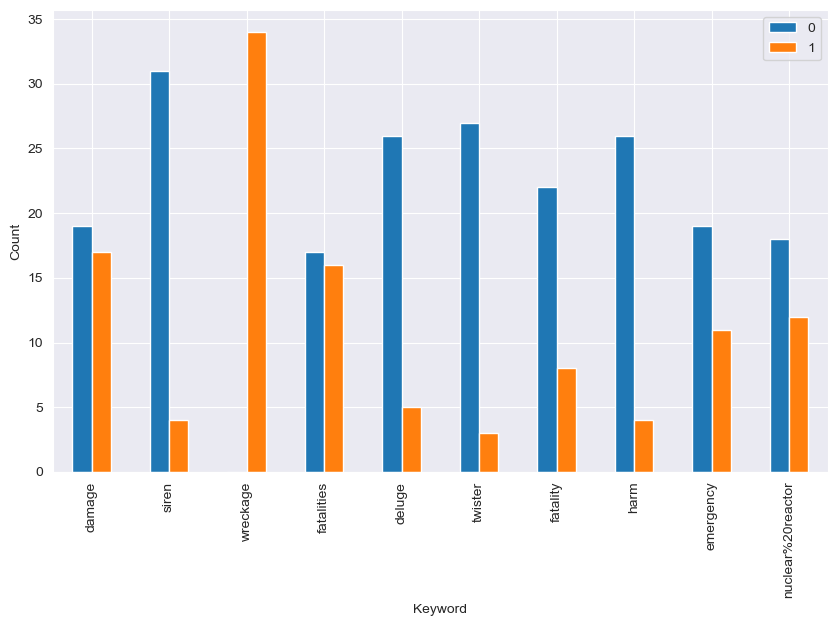

In [178]:
target_counts = pd.DataFrame(index=popular_keywords, columns=[0, 1])
for i in popular_keywords:
    target_counts.loc[i] = train[train.keyword == i].target.value_counts()

ax = target_counts.plot.bar(figsize=(10, 6))
ax.set_xlabel('Keyword')
ax.set_ylabel('Count')
plt.show()

**Выводы**: есть несколько столбцов, которые имеют преемущественно определенный таргет, что может быть использовано для определения в тест выборке (например: wreckage, siren, deluge, twister, harm)

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [179]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,NaN,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [180]:
a = data.keyword + " " + data.location + " " + data.text
data = data.drop(columns=['id', 'keyword', 'location'])
data['text'] = a
train_new, test_new = train_test_split(data, test_size=0.3, random_state=42)

In [181]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [182]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(train_new.text)
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [183]:
(X.toarray() == 0).all()

False

In [184]:
X.toarray().shape

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [185]:
import string

In [186]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return np.array([True if s.find(f'{i}') != -1 else False for i in range(10)]).any()

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return np.array([True if s.find(f'{i}') != -1 else False for i in string.punctuation]).any()

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return len(s) > 1 and s[0] == '#'

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return len(s) > 1 and s[0] == '@'

def investigate_vocabulary(vocabulary):
    # -- YOUR CODE HERE --
    print('With digit:      ', np.array(list(map(contains_digit, vocabulary))).sum()
          )
    print('With punctuation:', np.array(list(map(contains_punctuation, vocabulary))).sum()
          )
    print('Hashtags:        ', np.array(list(map(is_hashtag, vocabulary))).sum()
          )
    print('Mentions:        ', np.array(list(map(is_mention, vocabulary))).sum()
          )


In [187]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [188]:
investigate_vocabulary(vec.vocabulary_
                       )

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [189]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [190]:
vec_tw = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
X = vec_tw.fit_transform(train_new.text)
X.toarray()

/Users/nikitaevseev/anaconda3/envs/Downloads/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [191]:
investigate_vocabulary(vec_tw.vocabulary_
                       )

With digit:       3939
With punctuation: 7338
Hashtags:         1469
Mentions:         1678


**Сравнение:** Существенная разница видна в выделении пунктуации, хештегах и упоминаний, что хорошо) Результат стал лучше

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [192]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikitaevseev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [196]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return np.array([True if i in string.ascii_letters else False for i in s]).all()

def is_emoji(s: str):
    # Проверка, является ли слово смайликом
    return np.array([True if s.find(f'{i}') != -1 else False for i in ['[', ']', '{', '}', '(', ')']]).any() and np.array([True if i in string.punctuation else False for i in s]).all()

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return len(s) > 1 and s[0] == '#' and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]:
    # Кастомный токенайзер
    tokens = np.array(TweetTokenizer().tokenize(s.lower()))
    return list(map(SnowballStemmer('english').stem, list(tokens[np.vectorize(contains_only_latin_letters)(tokens) * np.vectorize(lambda x: x not in stopwords.words('english'))(tokens) | np.vectorize(is_emoji)(tokens) | np.vectorize(is_hashtag)(tokens)])))

In [197]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [198]:
train_new.iloc[:10].text.values

array(['bridge%20collapse  Ashes 2015: Australia\x89Ûªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0',
       'hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @bmurph1019 \n@hail_Youtsey . @termn8r13 \n#GoBlue #WrestleOn http://t.co/OasKgki6Qj',
       'police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR',
       'rioting  Still rioting in a couple of hours left until I have to be up for class.',
       'wounds Lake Highlands Crack in the path where I wiped out this morning during beach run. Surface wounds on left elbow and right knee. http://t.co/yaqRSximph',
       'airplane%20accident Somewhere Out There Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB',
       "bloody Isolated City In World Perth 'I came to kill Indians...for FUN': Video of smirking and r

In [199]:
for i in train_new.iloc[:10].text.values:
    print(custom_tokenizer(i))

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', 'suspect

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [200]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
tr = vectorizer.fit_transform(train_new.text)
te = vectorizer.transform(test_new.text)
tr.shape

/Users/nikitaevseev/anaconda3/envs/Downloads/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 10485)

2. Обучите LogisticRegression на полученных признаках.


In [201]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42).fit(tr, train_new.target)
logreg.predict(te)

array([0, 0, 1, ..., 1, 1, 1])

3. Посчитайте метрику f1-score на тестовых данных.

In [202]:
from sklearn.metrics import f1_score

print('F1 score:', f1_score(test_new.target, logreg.predict(te)))

F1 score: 0.752017213555675


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [203]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec_tf = TfidfVectorizer(tokenizer=custom_tokenizer)
tr_tf = vec_tf.fit_transform(train_new.text)
te_tf = vec_tf.transform(test_new.text)
logreg = LogisticRegression(random_state=13).fit(tr_tf, train_new.target)
print('F1 score:', f1_score(test_new.target, logreg.predict(te_tf)))

/Users/nikitaevseev/anaconda3/envs/Downloads/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7412353923205343


1. **Ответ:** качество ухудшилось, но не сильно

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [204]:
# 2
vec_tf = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
tr_tf = vec_tf.fit_transform(train_new.text)
te_tf = vec_tf.transform(test_new.text)
logreg = LogisticRegression(random_state=13).fit(tr_tf, train_new.target)
print('F1 score:', f1_score(test_new.target, logreg.predict(te_tf)))

/Users/nikitaevseev/anaconda3/envs/Downloads/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7412353923205343


In [207]:
tr_tf.toarray().shape

(5329, 10485)

2. **Ответ:** Размер не изменился, качество тоже (ничего вообще не поменялось)

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [208]:
# 3
vec_tf = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=0.0005)
tr_tf = vec_tf.fit_transform(train_new.text)
te_tf = vec_tf.transform(test_new.text)
logreg = LogisticRegression(random_state=13).fit(tr_tf, train_new.target)
print('F1 score:', f1_score(test_new.target, logreg.predict(te_tf)))

/Users/nikitaevseev/anaconda3/envs/Downloads/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7439024390243901


In [209]:
tr_tf.toarray().shape

(5329, 3137)

3. **Ответ:** Размер уменьшился в 3 раза, качество же осталось примерно на том же уровне

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [210]:
from sklearn.feature_extraction.text import HashingVectorizer

vec_hash = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
tr_hash = vec_hash.fit_transform(train_new.text)
te_hash = vec_hash.transform(test_new.text)
logreg = LogisticRegression(random_state=13).fit(tr_hash, train_new.target)
print('F1 score:', f1_score(test_new.target, logreg.predict(te_hash)))

/Users/nikitaevseev/anaconda3/envs/Downloads/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7197771587743732


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Самый высокий результат получился у CountVectorizer

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [211]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
tr = vectorizer.fit_transform(train_new.text)
te = vectorizer.transform(test_new.text)
logreg = LogisticRegression(random_state=42).fit(tr, train_new.target)
print('F1 score:', f1_score(test_new.target, logreg.predict(te)))

/Users/nikitaevseev/anaconda3/envs/Downloads/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.752017213555675
